In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import random

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import feature

from skimage.filters import sobel
from skimage.morphology import watershed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from torchvision import transforms as tf

import h5py

from pathlib import Path
import nibabel as nib
from sklearn import preprocessing
from skimage import transform

# from tqdm import tqdm

# from imgaug import augmenters as iaaot as plt
import pandas as pd

In [2]:
import sys
sys.path.insert(0, '../networks/')
from Att_Net import Att_Net
sys.path.insert(0, '../lib/')
# help_functions.py
from help_functions import * 

In [3]:
class eye_dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, train=True, label=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.label = label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        img = np.zeros_like(image, dtype=np.float32)
        
        img += image
        label = None
        if self.train:
            label = self.label[idx]
#             msk = np.zeros((2,48,48), dtype=np.long)
#             msk[1] = label
#             msk[0] = 1-label
            
#             msk += label
            return (img, label)
        return img

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from pre_processing import my_PreProc
# from pixel_dcn import pixel_dcl


In [5]:
# [data paths]
path_local =  '../DRIVE_datasets_training_testing/'
train_imgs_original = 'DRIVE_dataset_imgs_train.hdf5'
train_groundTruth = 'DRIVE_dataset_groundTruth_train.hdf5'
train_border_masks = 'DRIVE_dataset_borderMasks_train.hdf5'
test_imgs_original = 'DRIVE_dataset_imgs_test.hdf5'
test_groundTruth = 'DRIVE_dataset_groundTruth_test.hdf5'
test_border_masks = 'DRIVE_dataset_borderMasks_test.hdf5'



#========= CONFIG FILE TO READ FROM =======
# config = configparser.RawConfigParser()
# config.read('../configuration.txt')
# #===========================================
# #run the training on invariant or local
# path_data = config.get('data paths', 'path_local')

#original test images (for FOV selection)
DRIVE_test_imgs_original = path_local + test_imgs_original

test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]
#the border masks provided by the DRIVE
DRIVE_test_border_masks = path_local + test_border_masks
test_border_masks = load_hdf5(DRIVE_test_border_masks)
# dimension of the patches
patch_height = 48
patch_width = 48
#the stride in case output with average
stride_height = 5
stride_width = 5
assert (stride_height < patch_height and stride_width < patch_width)
#model name
name_experiment = 'test'
path_experiment = '../' +name_experiment +'/'
#N full images to be predicted
Imgs_to_test = 20
#Grouping of the predicted images
N_visual = 1
#====== average mode ===========
average_mode = True

In [6]:
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_masks_test = None
if average_mode == True:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = path_local + test_groundTruth, #masks
        Imgs_to_test = Imgs_to_test,
        patch_height = patch_height,
        patch_width = patch_width,
        stride_height = stride_height,
        stride_width = stride_width
    )
    #masks_test = np.rollaxis(masks_test, 1, 2)
else:
    patches_imgs_test, patches_masks_test = get_data_testing(
        DRIVE_test_imgs_original = DRIVE_test_imgs_original,  #original
        DRIVE_test_groudTruth = path_local +test_groundTruth,  #masks
        Imgs_to_test = Imgs_to_test,
        patch_height = patch_height,
        patch_width = patch_width,
    )


the side H is not compatible with the selected stride of 5
img_h 584, patch_h 48, stride_h 5
(img_h - patch_h) MOD stride_h: 1
So the H dim will be padded with additional 4 pixels
the side W is not compatible with the selected stride of 5
img_w 565, patch_w 48, stride_w 5
(img_w - patch_w) MOD stride_w: 2
So the W dim will be padded with additional 3 pixels
new full images shape: 
(20, 1, 588, 568)

test images shape:
(20, 1, 588, 568)

test mask shape:
(20, 1, 584, 565)
test images range (min-max): 0.0 - 1.0
test masks are within 0-1

Number of patches on h : 109
Number of patches on w : 105
number of patches per image: 11445, totally for this dataset: 228900

test PATCHES images shape:
(228900, 1, 48, 48)
test PATCHES images range (min-max): 0.0 - 1.0


In [7]:
patches_imgs_test.shape

(228900, 1, 48, 48)

In [8]:
eye_dataset_test = eye_dataset(patches_imgs_test, 
                                      train=False, 
                                      label=None)


batch_size = 64

test_loader = torch.utils.data.DataLoader(dataset=eye_dataset_test, 
                                           batch_size=batch_size, 
                                           shuffle=False)



In [9]:
model = Att_Net(32)
model.cuda()
state_dict = torch.load('expr/att_bott/att_res_torch_190k.pth')
model.load_state_dict(state_dict)
model.eval()

Att_Net(
  (input_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): Sequential(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
    (1): ReLU6(inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
    (4): ReLU6(inplace)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block2): Sequential(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
    (1): ReLU6(inplace)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.997, affine=True, track_running_stats=True)
    (4): ReLU6(inplace)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block2_res): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
  (block3): Sequential(
   

In [10]:
pred_images = np.zeros((len(patches_imgs_test),2,2304)) 
# pred_images=patches_imgs_test
pred_images.shape

(228900, 2, 2304)

In [11]:
count =0
for image in test_loader:
    image = Variable(image.cuda())
    outputs = model(image)
#     print(outputs.shape)
#     print(outputs)
    for i in range(outputs.shape[0]):
        pred_images[count,:,:] =torch.exp(outputs)[i].data.cpu().numpy()
        count +=1

../networks/attention.py:249: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(logits)


In [12]:
pred_images.shape

(228900, 2, 2304)

In [13]:
pred_patches = pred_to_imgs(pred_images, patch_height)

In [14]:
pred_patches.shape

(228900, 1, 48, 48)

In [15]:
pred_patches[0][0]

array([[1.47322090e-02, 2.08248408e-03, 3.90150293e-04, ...,
        8.37613406e-05, 2.89784861e-04, 3.17513337e-03],
       [3.20635806e-03, 2.62030080e-04, 2.27413821e-05, ...,
        3.60492095e-06, 1.77570437e-05, 2.57782754e-04],
       [1.15135021e-03, 4.99553062e-05, 3.09304755e-06, ...,
        7.94915024e-07, 4.81964071e-06, 9.89641703e-05],
       ...,
       [6.41683023e-03, 1.98719115e-03, 5.65388298e-04, ...,
        2.47868942e-03, 2.05249968e-03, 4.36561089e-03],
       [2.34356560e-02, 7.00719142e-03, 1.86229451e-03, ...,
        4.33524931e-03, 3.31054046e-03, 8.45011882e-03],
       [7.52629936e-02, 2.40868665e-02, 7.35943066e-03, ...,
        6.00837683e-03, 5.36004128e-03, 1.83250383e-02]])

In [16]:
def image_gray(img, sz=10, color='gray'):
    plt.figure()
    plt.subplots(figsize=(sz,sz))
    plt.imshow(img, cmap=color)
    plt.show()

<Figure size 432x288 with 0 Axes>

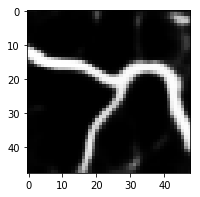

In [17]:
image_gray(pred_patches[5000][0],3)

<Figure size 432x288 with 0 Axes>

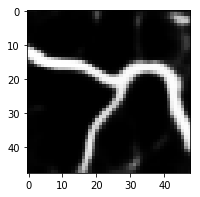

In [18]:
image_gray(pred_patches[5000][0],3)

N_patches_h: 109
N_patches_w: 105
N_patches_img: 11445
According to the dimension inserted, there are 20 full images (of 588x568 each)
(20, 1, 588, 568)
Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)


========  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)
y true pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)

Area under the ROC curve: 0.9740069516045

Area under Precision-Recall curve: 0.8902297894382326

Confusion matrix:  Custom threshold (for positive) of 0.5
[[3813721  146773]
 [  91865  485784]]
Global Accuracy: 0.9474150550125899
Specificity: 0.9629407341609405
Sensitivity: 0.8409674387041266
Precision: 0.7679687364142678

Jaccard similarity score: 0.9474150550125899

F1 score (F-measure): 0.8

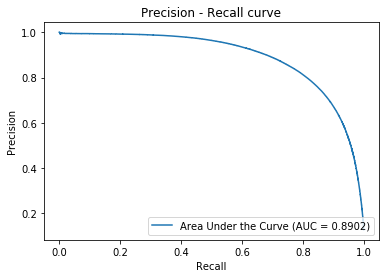

In [19]:
pred_imgs = None
orig_imgs = None
gtruth_masks = None
if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    orig_imgs = my_PreProc(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
else:
    pred_imgs = recompone(pred_patches,13,12)       # predictions
    orig_imgs = recompone(patches_imgs_test,13,12)  # originals
    gtruth_masks = recompone(patches_masks_test,13,12)  #masks
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))
visualize(group_images(orig_imgs,N_visual),path_experiment+"all_originals")#.show()
visualize(group_images(pred_imgs,N_visual),path_experiment+"all_predictions")#.show()
visualize(group_images(gtruth_masks,N_visual),path_experiment+"all_groundTruths")#.show()
#visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    visualize(total_img,path_experiment+name_experiment +"_Original_GroundTruth_Prediction"+str(i))#.show()


#====== Evaluate the results
print("\n\n========  Evaluate the results =======================")
#predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks, test_border_masks)  #returns data only inside the FOV
print("Calculating results only inside the FOV:")
print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")

#Area under the ROC curve
AUC_ROC = roc_auc_score(y_true, y_scores)
# fpr, tpr, thresholds = roc_curve((y_true), y_scores)

# test_integral = np.trapz(tpr,fpr) #trapz is numpy integration
print("\nArea under the ROC curve: " +str(AUC_ROC))
# roc_curve =plt.figure()
# plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
# plt.title('ROC curve')
# plt.xlabel("FPR (False Positive Rate)")
# plt.ylabel("TPR (True Positive Rate)")
# plt.legend(loc="lower right")
# plt.savefig(path_experiment+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " +str(precision))

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(path_experiment+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

In [ ]:
nn.BatchNorm2d()

In [ ]:
nn.Dropout2d()